<a href="https://colab.research.google.com/github/shreyakakachery/daps-subset/blob/main/DAPS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install praat-parselmouth

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 51.4 MB/s eta 0:00:00


In [ ]:
!pip install pydub

In [ ]:
# Import libraries
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import parselmouth
import seaborn as sns
from pydub import AudioSegment
import os
# import os
# import pandas as pd

In [ ]:
# Audio file pathss
f1_path = '/content/drive/My Drive/DAPS/DAPS-subset/f/f10_script1.wav'
f2_path = '/content/drive/My Drive/DAPS/DAPS-subset/f10/f10_script2.wav'
m1_path = '/content/drive/My Drive/DAPS/DAPS-subset/m10/m10_script1.wav'
m2_path = '/content/drive/My Drive/DAPS/DAPS-subset/m10/m10_script2.wav'
f1_balcony_path = '/content/drive/My Drive/DAPS/DAPS-subset/f10/f10_script1_balcony.wav' # to test normalisation

## need a better way to load data since I'll be working with >2 participants

y1 (and y2): This is the audio time series (a NumPy array) containing the amplitude of the waveform. It's a 1D array where each element corresponds to the amplitude of the audio signal at each time step.

sr1 (and sr2): This is the sampling rate, which indicates how many samples per second were used to record the audio. The default sampling rate in librosa is 22050 Hz, but you can specify a different rate if needed.

**y1 holds the audio signal from audio_file_1 and sr1 holds its sampling rate.**

In [ ]:
# y1, sr1 = librosa.load(f1)
# y2, sr2 = librosa.load(f2)

Following parselmouth documentation
https://parselmouth.readthedocs.io/en/stable/

In [ ]:
sns.set() # Use seaborn's default style to make attractive graphs
plt.rcParams['figure.dpi'] = 100 # Show nicely large images in this notebook

In [ ]:
# convert .wav file to Parselmouth Sound object (using .wav file path) to
# access its values and properties to plor using matplotlib
f1_balcony = parselmouth.Sound(f1_balcony_path)

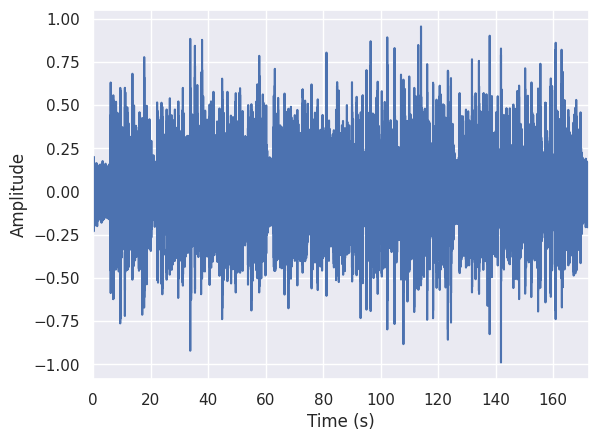

In [ ]:
# plot waveform
plt.figure()
plt.plot(f1_balcony.xs(), f1_balcony.values.T)
plt.xlim([f1_balcony.xmin, f1_balcony.xmax])
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show() # or plt.savefig("sound.png"), or plt.savefig("sound.pdf")

In [ ]:
# # It is also possible to extract part of the speech fragment and plot it separately
# snd_part = snd.extract_part(from_time=0.9, preserve_times=True)

In [ ]:
# # plot extracted region
# plt.figure()
# plt.plot(snd_part.xs(), snd_part.values.T, linewidth=0.5)
# plt.xlim([snd_part.xmin, snd_part.xmax])
# plt.xlabel("time [s]")
# plt.ylabel("amplitude")
# plt.show()

Parselmouth Spectrogram and Intensity

In [ ]:
# defining how to plot
def draw_spectrogram(spectrogram, dynamic_range=70):
    X, Y = spectrogram.x_grid(), spectrogram.y_grid()
    sg_db = 10 * np.log10(spectrogram.values)
    plt.pcolormesh(X, Y, sg_db, vmin=sg_db.max() - dynamic_range, cmap='afmhot')
    plt.ylim([spectrogram.ymin, spectrogram.ymax])
    plt.xlabel("time [s]")
    plt.ylabel("frequency [Hz]")

def draw_intensity(intensity):
    plt.plot(intensity.xs(), intensity.values.T, linewidth=3, color='w')
    plt.plot(intensity.xs(), intensity.values.T, linewidth=1)
    plt.grid(False)
    plt.ylim(0)
    plt.ylabel("intensity [dB]")

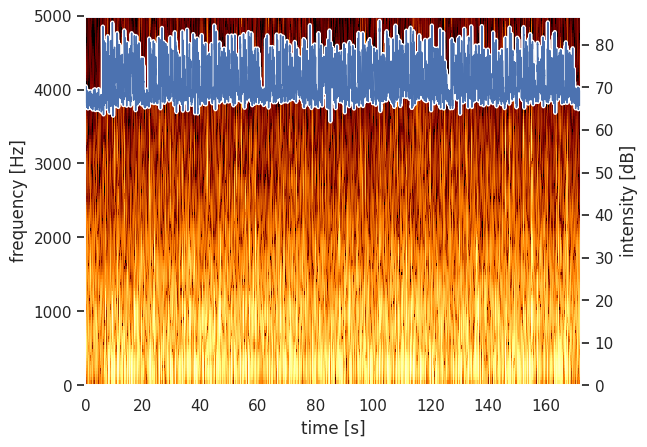

In [ ]:
# use Praat (through Parselmouth) to calculate the spectrogram and
# intensity to actually plot the intensity curve overlaid on the spectrogram
intensity = f1_balcony.to_intensity()
spectrogram = f1_balcony.to_spectrogram()
plt.figure()
draw_spectrogram(spectrogram)
plt.twinx()
draw_intensity(intensity)
plt.xlim([f1_balcony.xmin, f1_balcony.xmax])
#plt.figure(figsize=(20, 5))  # (width, height) in inches
plt.show()


Calculate pitch and plot it on spectrogram

In [ ]:
# define pitch function
def draw_pitch(pitch):
    # Extract selected pitch contour, and
    # replace unvoiced samples by NaN to not plot
    pitch_values = pitch.selected_array['frequency']
    pitch_values[pitch_values==0] = np.nan
    plt.plot(pitch.xs(), pitch_values, 'o', markersize=5, color='w')
    plt.plot(pitch.xs(), pitch_values, 'o', markersize=2)
    plt.grid(False)
    plt.ylim(0, pitch.ceiling)
    plt.ylabel("fundamental frequency [Hz]")

In [ ]:
pitch = f1_balcony.to_pitch()

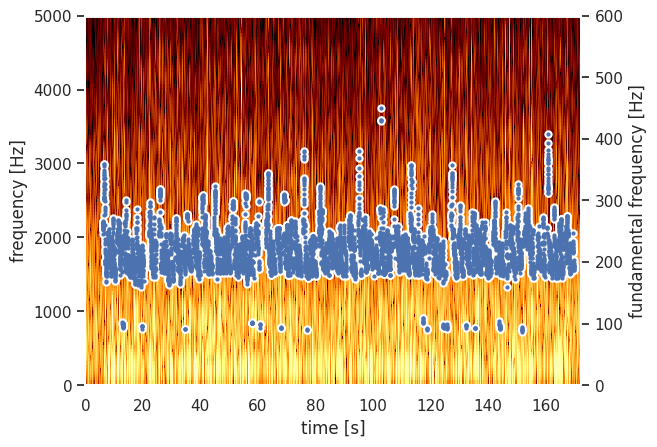

In [ ]:
plt.figure()
draw_spectrogram(spectrogram)
plt.twinx()
draw_pitch(pitch)
plt.xlim([f1_balcony.xmin, f1_balcony.xmax])
plt.show()

In [ ]:
# partial
f1_balcony_part = f1_balcony.extract_part(from_time=170, preserve_times=True)

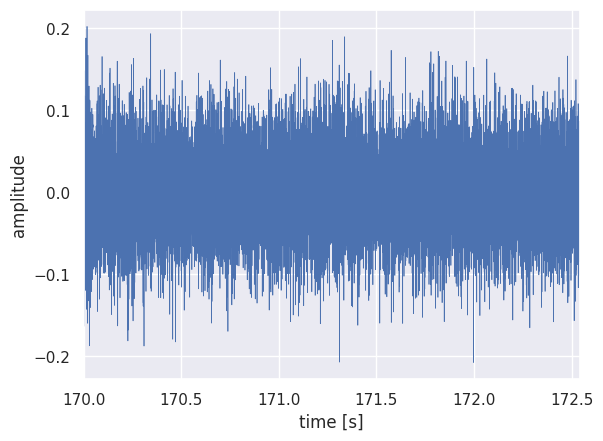

In [ ]:
plt.figure()
plt.plot(f1_balcony_part.xs(), f1_balcony_part.values.T, linewidth=0.5)
plt.xlim([f1_balcony_part.xmin, f1_balcony_part.xmax])
plt.xlabel("time [s]")
plt.ylabel("amplitude")
plt.show()

In [ ]:
pitch_balcony = f1_balcony_part.to_pitch()

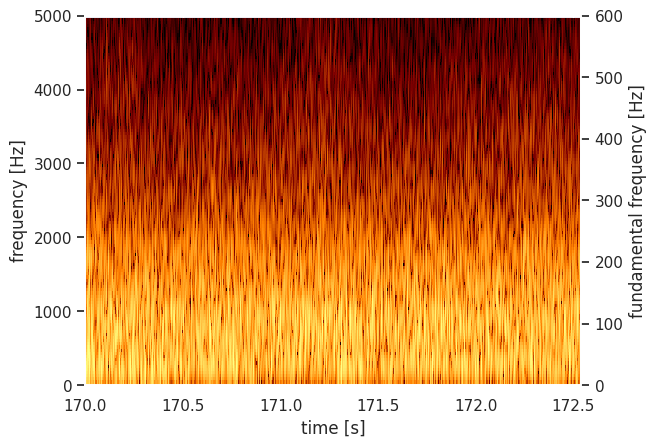

In [ ]:
plt.figure()
draw_spectrogram(spectrogram)
plt.twinx()
draw_pitch(pitch_balcony)
plt.xlim([f1_balcony_part.xmin, f1_balcony_part.xmax])
plt.show()

## something is wrong with the spectrogram methinks

Normalisation
- pydub normalizes to a specific dBFS, ideal for adjusting the overall loudness.
- librosa normalizes the peak amplitude, which is useful for making sure the
audio levels are within a specific range.

In [ ]:
# Function to normalize an audio file
def normalize_audio(audio_file, target_dBFS=-20.0):
    # Load audio file
    sound = AudioSegment.from_file(audio_file)

    # Calculate the difference in dBFS
    change_in_dBFS = target_dBFS - sound.dBFS

    # Apply the normalization
    normalized_sound = sound.apply_gain(change_in_dBFS)

    return normalized_sound

# Directory containing your audio files
input_directory = "path_to_audio_files"
output_directory = "path_to_normalized_files"

# Normalize each file in the directory
for filename in os.listdir(input_directory):
    if filename.endswith(".wav"):  # Ensure only .wav files are processed
        file_path = os.path.join(input_directory, filename)
        normalized_audio = normalize_audio(file_path)

        # Save the normalized audio
        output_path = os.path.join(output_directory, filename)
        normalized_audio.export(output_path, format="wav")

print("Audio files normalized successfully!")